In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Provided data
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

# Calculate durations
start = gs_data['start']
end = gs_data['end']
stadials = [e - s for s, e in zip(start, end)]
interstadials = [start[i+1] - end[i] for i in range(len(start)-1)]
combined = stadials + interstadials

# Calculate medians
med_stadial = np.median(stadials)
med_interstadial = np.median(interstadials)
med_combined = np.median(combined)

# print the median values
print(f"Median Stadial Length: {med_stadial} years")
print(f"Median Interstadial Length: {med_interstadial} years")
print(f"Median Combined Length: {med_combined} years")

# Create subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=('Stadial Lengths', 'Interstadial Lengths', 'Combined Lengths'))

# Add histograms
fig.add_trace(go.Histogram(x=stadials, nbinsx=20, name='Stadial'), row=1, col=1)
fig.add_trace(go.Histogram(x=interstadials, nbinsx=20, name='Interstadial'), row=1, col=2)
fig.add_trace(go.Histogram(x=combined, nbinsx=20, name='Combined'), row=1, col=3)

# Add median lines
fig.add_vline(x=med_stadial, row=1, col=1, line_dash="dash")
fig.add_vline(x=med_interstadial, row=1, col=2, line_dash="dash")
fig.add_vline(x=med_combined, row=1, col=3, line_dash="dash")

# Update axes labels
for i in range(1, 4):
    fig.update_xaxes(title_text='Years', row=1, col=i)
    fig.update_yaxes(title_text='Frequency', row=1, col=i)

fig.update_layout(height=500, width=1200, showlegend=False, title_text="Durations of Stadial and Interstadial Phases with Medians")

fig.show()


Median Stadial Length: 920.0 years
Median Interstadial Length: 590.0 years
Median Combined Length: 820.0 years


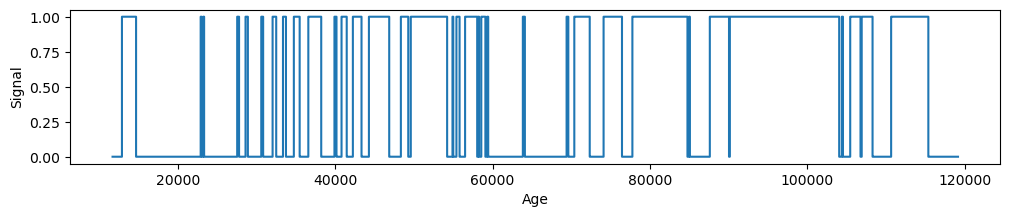

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = 0

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
# plt.title("Irregular Square Wave Signal")
plt.show()


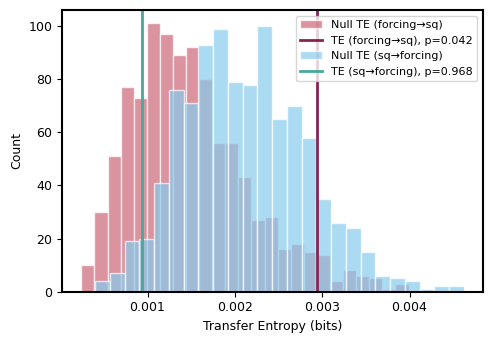

True


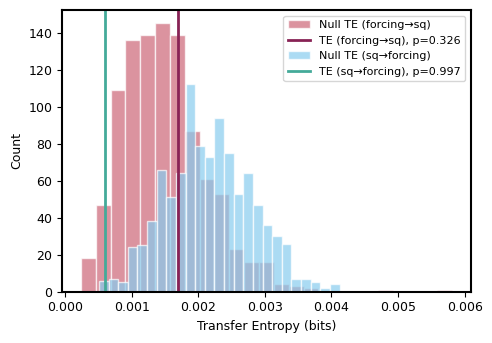

False


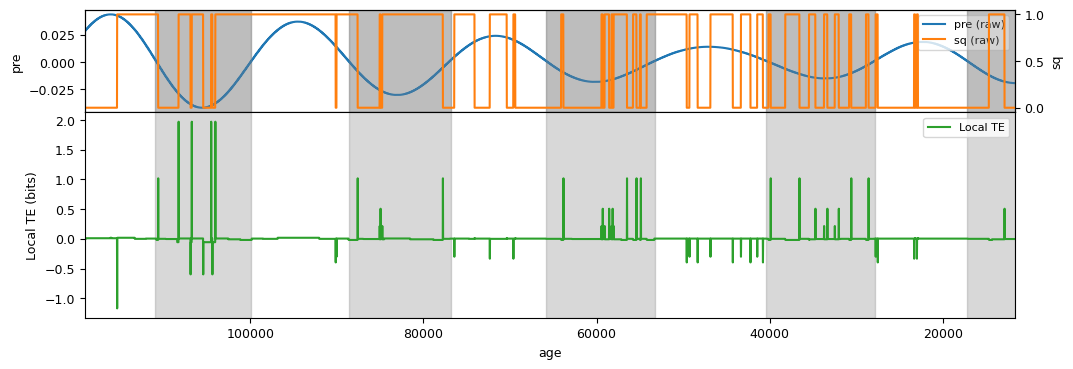

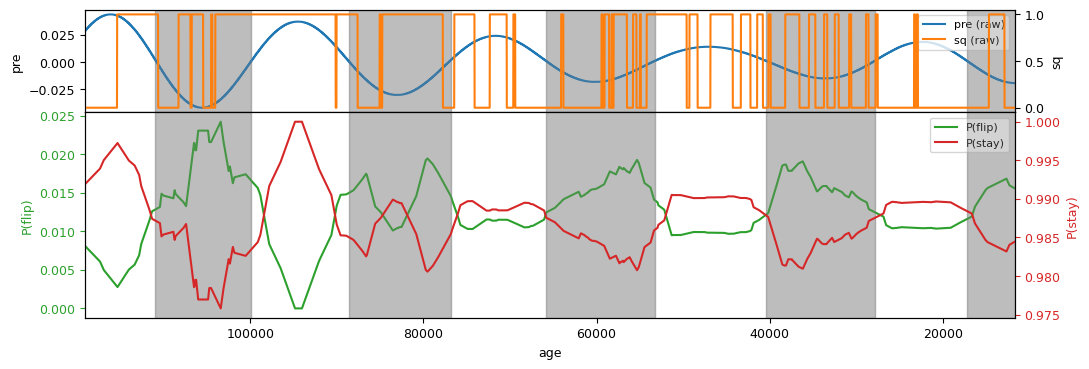

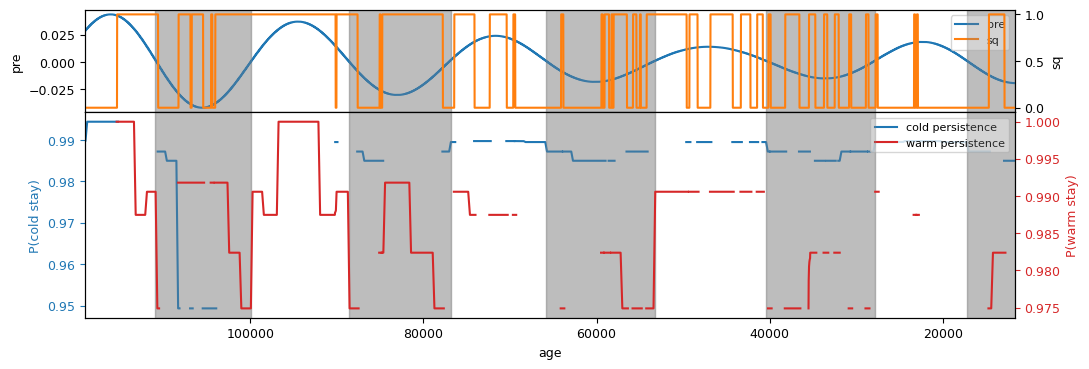

In [3]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

dt=20

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), dt, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values      # forcing (obliquity)
sq = df_sq_i['sq'].values    # target (residual)


result,fig,te_pre=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='quantile', binary=True, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

print(result)

result, fig ,te_obl= sa.transfer_entropy_surrogate_test(obl, sq, k=1, forcing_bins=6, sq_bins=2, sq_method='quantile', n_surr=1000)
print(result)


from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

LTE = sa.local_TE(df_pre_i, df_sq_i,
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)

Lp = sa.local_prob(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=10)

     dt     te_xy   p_xy     te_yx   p_yx  sig_uni
0    10  0.001462  0.034  0.000467  0.973     True
1    20  0.002939  0.022  0.000933  0.972     True
2    30  0.004610  0.024  0.001391  0.977     True
3    40  0.006044  0.025  0.001865  0.976     True
4    50  0.007858  0.016  0.002334  0.974     True
5    60  0.009282  0.029  0.002784  0.935     True
6    70  0.011096  0.024  0.003577  0.957     True
7    80  0.012964  0.017  0.003650  0.950     True
8    90  0.014733  0.014  0.004115  0.946     True
9   100  0.016256  0.017  0.005044  0.936     True
10  110  0.017617  0.019  0.005105  0.959     True
11  120  0.019074  0.013  0.005647  0.937     True
12  200  0.031317  0.025  0.010305  0.910     True


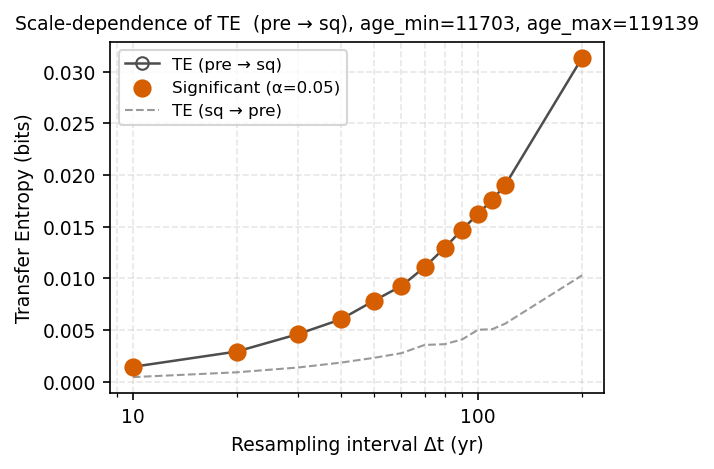

In [5]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


dt_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,110,120, 200]          # yr

# run the scan
te_df, (fig, ax) = sa.te_vs_dt_scan(
    df_sq.copy(),                 # your raw sq-series
    dt_steps,
    forcing = 'pre',
    forcing_bins=6, sq_bins=2,
    n_surr=1000, alpha=0.05,
    sq_method='hist',            # or 'quantile', 'kmeans'
    dpi=150)

# te_df now holds the numbers:
print(te_df)

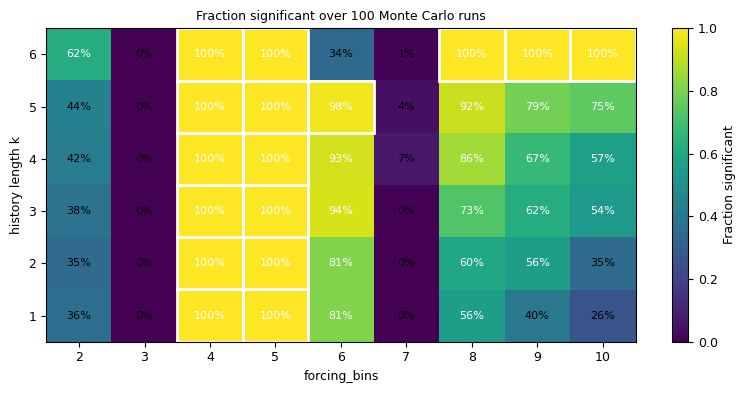

In [8]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 20, if_plot=False)


fractions= sa.mc_TE_heatmap(
    pre =df_pre_i['pre'].values,
    sq =df_sq_i['sq'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    plot=True)

# Stability of TE to event identifications

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def perturb_sequence(df, n_events=10, min_len=1, max_len=10, random_state=None, plot=True):
    """
    Perturb a binary stadial/interstadial sequence by inserting N spurious events.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns 'age' and 'sq' (0 or 1).
    n_events : int
        Number of random segments to insert.
    max_len : int
        Maximum length (in samples) of each inserted segment.
    random_state : int or None
        Seed for reproducibility.
    plot : bool
        If True, overlays original vs perturbed sequences.

    Returns
    -------
    df_pert : pandas.DataFrame
        A copy of `df` with new column 'sq_pert' for the perturbed sequence.
    f1 : float
        Macro-averaged F₁ score comparing original 'sq' to 'sq_pert'.
    """
    rng = np.random.RandomState(random_state)
    seq_orig = df['sq'].values
    seq_pert = seq_orig.copy()
    L = len(seq_orig)

    # Insert random segments
    for _ in range(n_events):
        length = rng.randint(min_len, max_len + 1)
        start = rng.randint(0, L - length)
        new_state = rng.choice([0, 1])
        seq_pert[start:start + length] = new_state

    # Compute F1 (macro-average)
    f1 = f1_score(seq_orig, seq_pert, average='macro')

    # Build output DataFrame
    df_pert = df.copy()
    df_pert['sq'] = seq_pert

    # Plot overlay
    if plot:
        plt.figure(figsize=(12, 3))
        plt.step(df['age'], seq_orig, where='post', label='Original', linewidth=1)
        plt.step(df['age'], seq_pert, where='post', label='Perturbed', alpha=0.7, linewidth=1)
        plt.xlabel('Age')
        plt.ylabel('sq')
        plt.title(f'Original vs Perturbed (F₁₍macro₎ = {f1:.3f})')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    return df_pert, f1


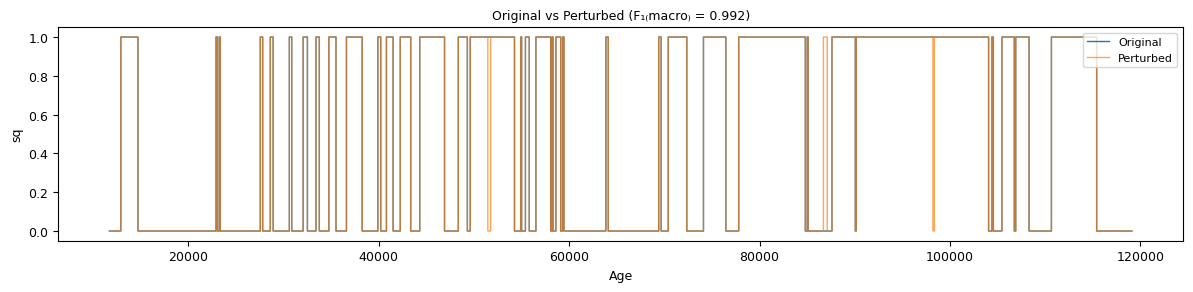

Perturbed F₁ score: 0.992


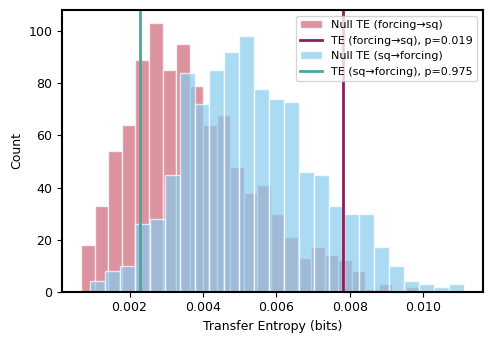

In [238]:
# assuming df_sq is your original DataFrame with 'age' and 'sq':
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 50, if_plot=False)
df_pert, f1 = perturb_sequence(df_sq_i, n_events=10, min_len=3, max_len=10, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values
sq  = df_pert['sq'].values
result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)


In [151]:
result

True

# Monte Carlo

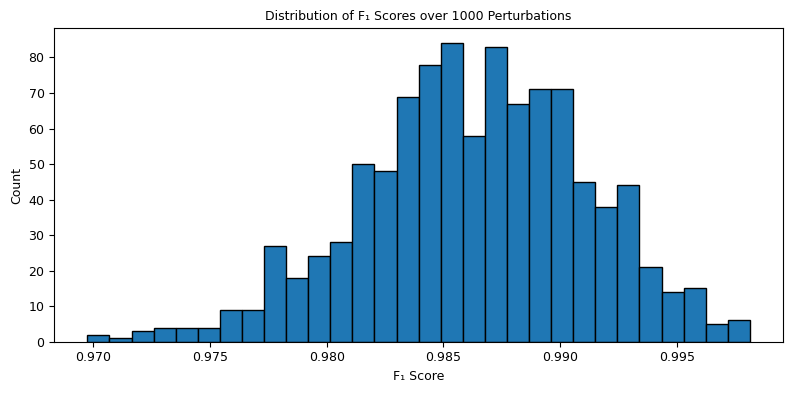

TE test was significant in 69.3% of the 1000 runs


In [239]:
import numpy as np
import matplotlib.pyplot as plt

n_iter = 1000
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = perturb_sequence(
        df_sq_i,
        n_events=10,
        min_len=2,
        max_len=10,
        plot=False,
        random_state=i
    )
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# Plot histogram of F1 scores
plt.figure(figsize=(8, 4))
plt.hist(f1_scores, bins=30, edgecolor='k')
plt.xlabel('F₁ Score')
plt.ylabel('Count')
plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
plt.tight_layout()
plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


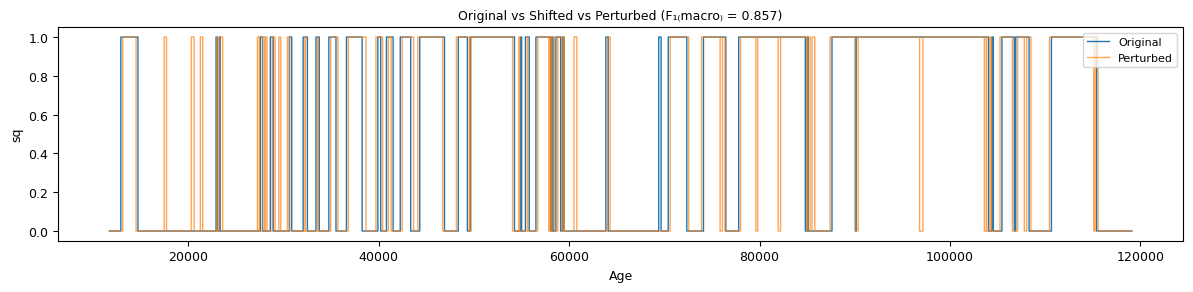

Perturbed F₁ score: 0.857


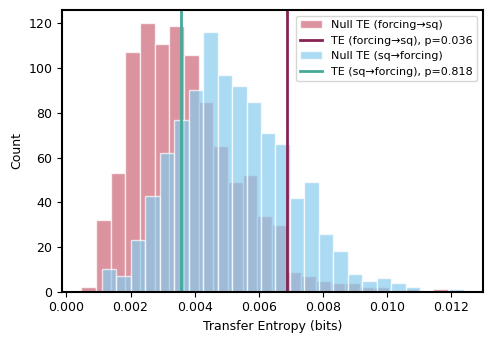

In [302]:
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


# assuming df_sq is your original DataFrame with 'age' and 'sq':
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 50, if_plot=False)
df_pert, f1 = syn_t.perturb_sequence_v2(df_sq_i, n_events=41, min_len=3, max_len=6, trans_shift=4, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values
sq  = df_pert['sq'].values
result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)


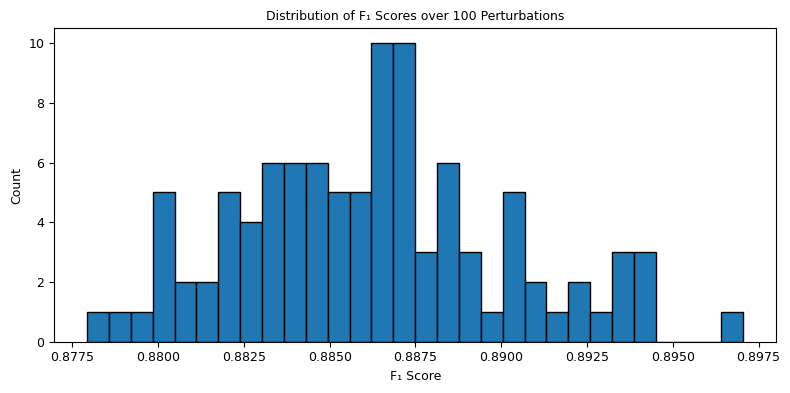

TE test was significant in 54.0% of the 100 runs


In [289]:
import numpy as np
import matplotlib.pyplot as plt

n_iter = 100
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = perturb_sequence_v2(df_sq_i, n_events=41, min_len=1, max_len=1, trans_shift=4, plot=False)
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# Plot histogram of F1 scores
plt.figure(figsize=(8, 4))
plt.hist(f1_scores, bins=30, edgecolor='k')
plt.xlabel('F₁ Score')
plt.ylabel('Count')
plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
plt.tight_layout()
plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


[  2.           2.14186884   2.29380107   2.45651051   2.63076166
   2.81737322   3.01722195   3.23124684   3.46045346   3.70591872
   3.96879592   4.25032016   4.55181415   4.87469445   5.22047808
   5.59078966   5.98736909   6.41207964   6.8669168    7.35401756
   7.87567053   8.43432665   9.03261072   9.67333373  10.35950605
  11.09435161  11.88132301  12.72411777  13.62669568  14.59329744
  15.62846454  16.73706061  17.9242943   19.19574372  20.55738268
  22.0156087   23.57727314  25.24971334  27.04078712  28.95890968
  31.01309315  33.21298893  35.56893304  38.09199469  40.79402825
  43.687729    46.78669273  50.10547965  53.6596828   57.46600129
  61.54231878  65.90778749  70.58291818  75.58967657  80.95158645
  86.69384031  92.84341761  99.42921162 106.4821651  114.03541575
 122.12445186 130.78727906 140.06459888 150.        ]
max-power row = 59   →  period ≈ 23.6 ka


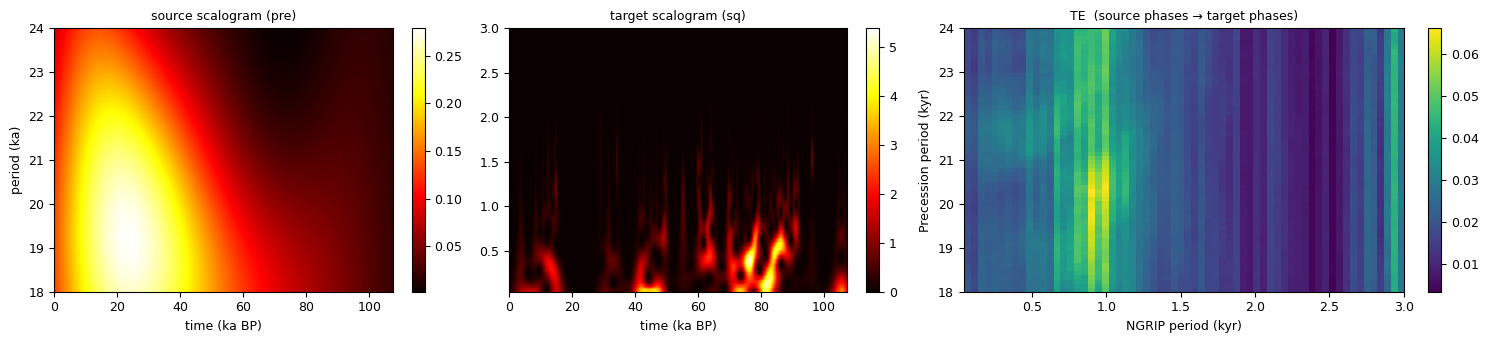

[[0.01686132 0.01404891 0.01960618 ... 0.02861689 0.04350975 0.02914294]
 [0.01747272 0.01503285 0.01973599 ... 0.02824016 0.04157414 0.02968131]
 [0.01668159 0.01528579 0.0206669  ... 0.02852002 0.04140974 0.02993964]
 ...
 [0.02086742 0.01764761 0.02378805 ... 0.02452048 0.04210877 0.02794413]
 [0.02075606 0.01721858 0.02385272 ... 0.02433476 0.04259187 0.02819821]
 [0.02071007 0.01633556 0.02379879 ... 0.0242114  0.04311916 0.02894486]]


In [6]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

te_mat, p_src, p_trg = sa.freq_resolved_te(
    x = pre,             # forcing   (chronological order!)
    y = sq,              # response
    sampling_period = dt,     # yr/pt
    # source band: narrow around 20 ka
    src_min_period = 18_000,
    src_max_period = 24_000,
    n_src_scales   = 64,
    # target band: 0.1–3 ka
    trg_min_period = 2*dt,
    trg_max_period = 3_000,
    n_trg_scales   = 64,
    k = 1,
    plot = True,
    source_vname='Precession',       # e.g. 'pre'
    target_vname='NGRIP'        # e.g. 'sq'
)
print(te_mat)

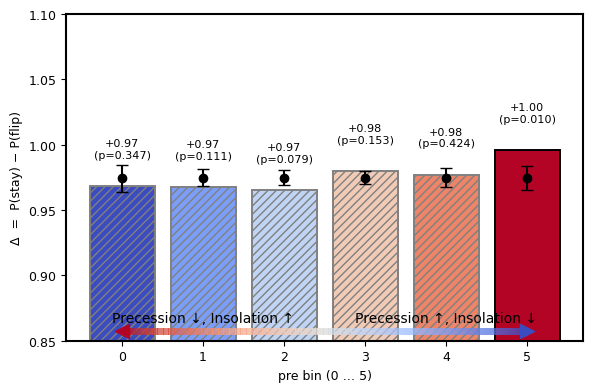

In [309]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre_i, df_sq_i,
        forcing_column='pre',
        target_column='sq',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        y_min=0.85,
        y_max=1.1,
        random_state=0   # reproducible
)

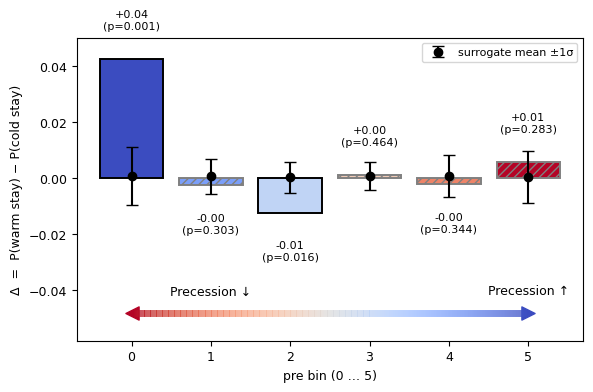

In [310]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

delta, mu, sd, p = sa.prob_prebins_staydiff_surr(
    df_pre      = df_pre_i.copy(),
    df_sq       = df_sq_i.copy(),
    forcing_column='pre',
    target_column='sq',
    nbins_pre   = 6,
    n_surr      = 1000,
    alpha       = 0.05,
    random_state=0
)